<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/diffraction_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: study diffraction patterns
- thick vs thin GO
- unaligned sheets of GO

# Resources
- https://wiki.fysik.dtu.dk/ase/ase/build/build.html
- https://en.wikipedia.org/wiki/Low-energy_electron_diffraction

# Setup

In [ ]:
%%bash
pip install abtem
pip install cupy

In [6]:
import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt

from ase.io import read, proteindatabank
from abtem.plot import show_atoms
from abtem.potentials import Potential

#from abtem.potentials import ArrayPotential
from abtem.waves import PlaneWave
from abtem.transfer import CTF, scherzer_defocus

from ase.build import graphene_nanoribbon
from abtem.plot import show_atoms
from abtem.detect import PixelatedDetector
import ase.build.attach


# Graphene

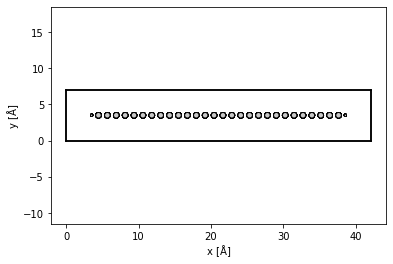

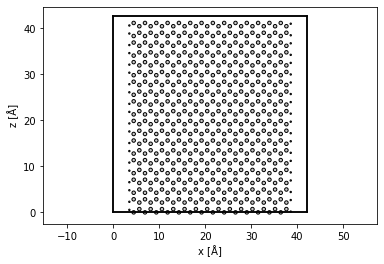

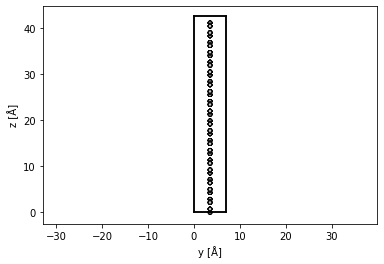

In [202]:
g = graphene_nanoribbon(14, 10, type='armchair', saturated=True,
                               vacuum=3.5)
show_atoms(g,plane='xy')
show_atoms(g,plane='xz')
show_atoms(g,plane='yz')


## Orient wrt electron beam in z direction

Want the thin hexogon pattern to be in xy, so swap y and z axes

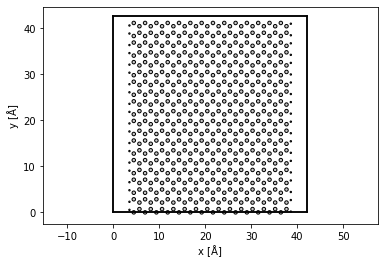

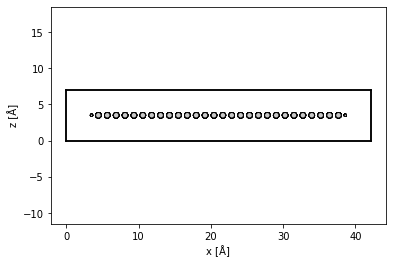

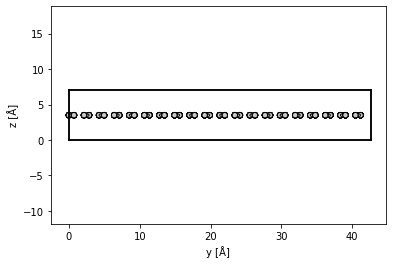

In [203]:
g.set_positions(g.get_positions()[:,[0,2,1]])
g.set_cell(np.diag(g.get_cell().array)[[0,2,1]])

show_atoms(g,plane='xy')
show_atoms(g,plane='xz')
show_atoms(g,plane='yz')

# Image

In [166]:
atoms = g
potential = Potential(atoms, 
                      sampling=0.1,
                      parametrization='lobato',
                      slice_thickness=0.5)

In [139]:
precalculated_potential = potential.build(pbar=True)

In [117]:
precalculated_potential_arr = precalculated_potential.array

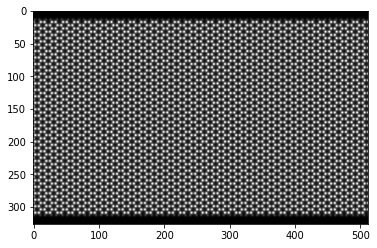

In [118]:
def show(arr2d):
  plt.imshow(arr2d,cmap='gray')
  
show(precalculated_potential_arr.mean(0))

In [173]:
exit_wave = PlaneWave(energy=300e3,sampling=.5).multislice(potential)


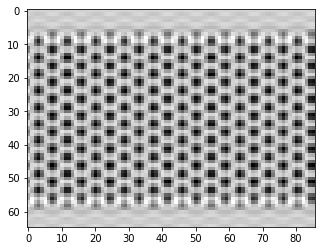

In [158]:
show(exit_wave.array[0].real)

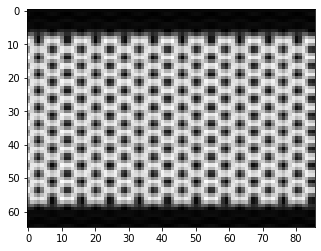

In [154]:
show(exit_wave.array[0].imag)

## Diffraction pattern

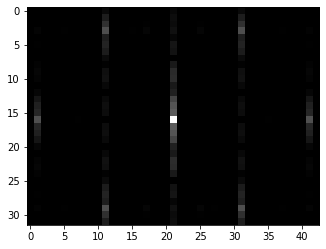

In [177]:

detector = PixelatedDetector()
intensity = detector.detect(exit_wave)
show(np.log(1+intensity[0]))

# Rotate

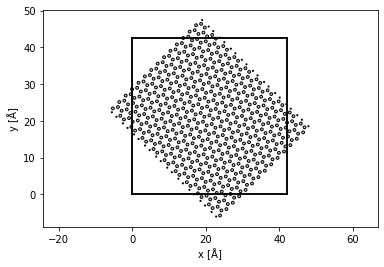

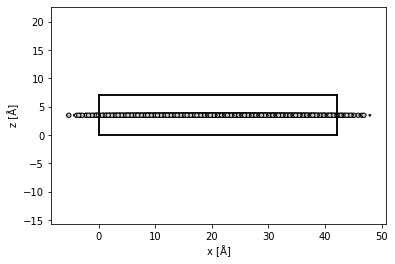

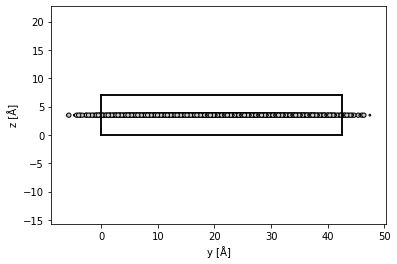

In [252]:
g_rot = g.copy()

g_rot.rotate(a=45,v=(0,0,1), center=g.get_center_of_mass())#rotate_cell=True) #
show_atoms(g_rot,plane='xy')
show_atoms(g_rot,plane='xz')
show_atoms(g_rot,plane='yz')

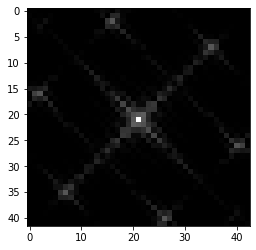

In [253]:
potential = Potential(g_rot, 
                      sampling=.5,
                      parametrization='lobato',
                      slice_thickness=0.5)
detector = PixelatedDetector()
exit_wave = PlaneWave(energy=300e3,sampling=.5).multislice(potential)
intensity = detector.detect(exit_wave)
show(np.log(1+intensity[0]))

# Multilayer

In [249]:
n_layers = 20
new_cell = np.diag(g.get_cell()).copy()
new_cell[-1] = new_cell[-1]*n_layers / 2
g_att = g.copy()
g_att.set_cell(new_cell)

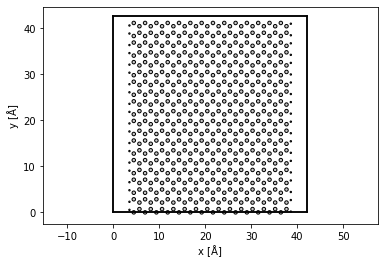

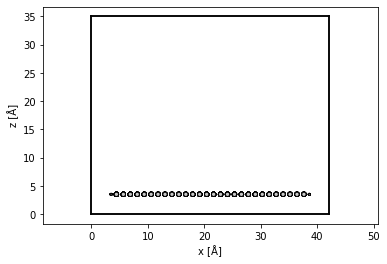

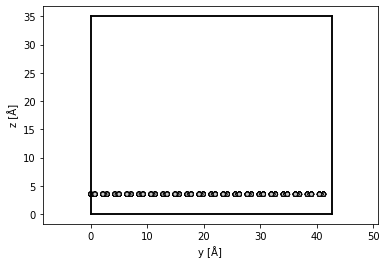

In [246]:
show_atoms(g_att,plane='xy')
show_atoms(g_att,plane='xz')
show_atoms(g_att,plane='yz')

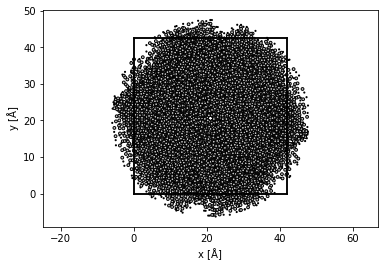

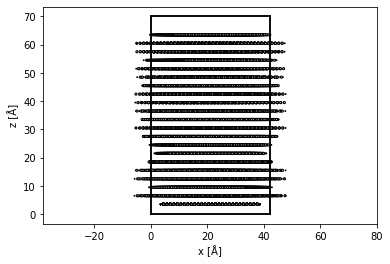

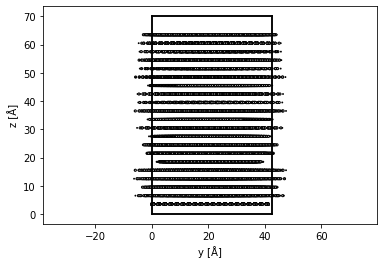

In [250]:
g_rot = g.copy()
angles = np.random.uniform(low=0,high=360,size=n_layers)
for angle in angles:
  g_rot.rotate(a=angle,v=(0,0,1), center=g.get_center_of_mass())#rotate_cell=True) #
  g_att = ase.build.attach.attach(g_att, g_rot, distance=3, direction=(0,0,1))

show_atoms(g_att,plane='xy')
show_atoms(g_att,plane='xz')
show_atoms(g_att,plane='yz')

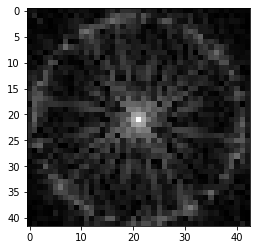

In [251]:
potential = Potential(g_att, 
                      sampling=.5,
                      parametrization='lobato',
                      slice_thickness=0.5)
detector = PixelatedDetector()
exit_wave = PlaneWave(energy=300e3,sampling=.5).multislice(potential)
intensity = detector.detect(exit_wave)
show(np.log(1+intensity[0]))

## how many layers thick for Thon ring?

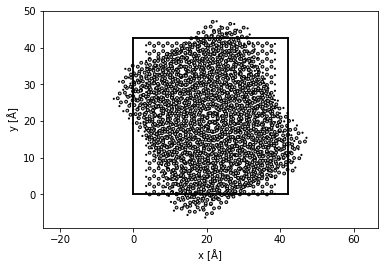

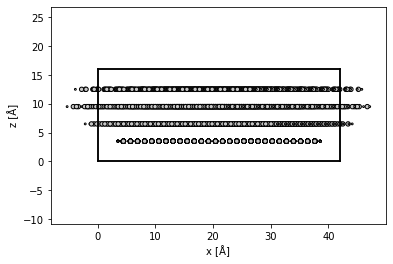

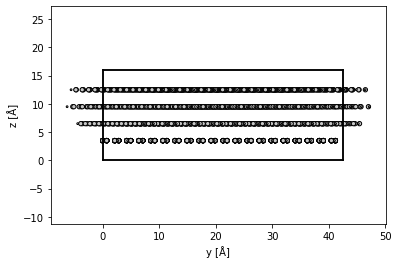

In [277]:
def make_multilayer(g,n_layers,distance=3):
  new_cell = np.diag(g.get_cell()).copy()
  new_cell[-1] = new_cell[-1]*n_layers
  g_att = g.copy()
  g_att.set_cell(new_cell)

  g_rot = g.copy()
  angles = np.random.uniform(low=0,high=360,size=n_layers)
  for angle in angles:
    g_rot.rotate(a=angle,v=(0,0,1), center=g.get_center_of_mass())#rotate_cell=True) #
    g_att = ase.build.attach.attach(g_att, g_rot, distance=distance, direction=(0,0,1))
  
  new_cell = np.diag(g.get_cell()).copy()
  pad_z = 3.5
  new_cell[-1] = g_att.get_positions()[:,-1].max() + pad_z# maxz
  g_att.set_cell(new_cell)
  return(g_att)

g_att = make_multilayer(g,n_layers=3)
show_atoms(g_att,plane='xy')
show_atoms(g_att,plane='xz')
show_atoms(g_att,plane='yz')



12.498944784582566

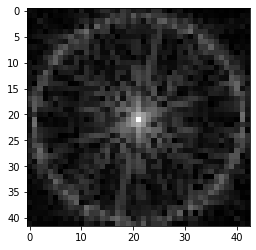

In [255]:
def make_diff_pattern(g_att):
  potential = Potential(g_att, 
                      sampling=.5,
                      parametrization='lobato',
                      slice_thickness=0.5)
  detector = PixelatedDetector()
  exit_wave = PlaneWave(energy=300e3,sampling=.5).multislice(potential)
  intensity = detector.detect(exit_wave)
  return(intensity)

intensity = make_diff_pattern(g_att)
show(np.log(1+intensity[0]))

In [290]:
n_layers_list = [2,3,4,5,10,30,100]
intensities = np.zeros((len(n_layers_list),)+ intensity.shape)
for i, n_layers in enumerate(n_layers_list):
  print(n_layers)
  g_att = make_multilayer(g,n_layers)
  intensities[i] = make_diff_pattern(g_att)


2




3




4




5




10




30




100


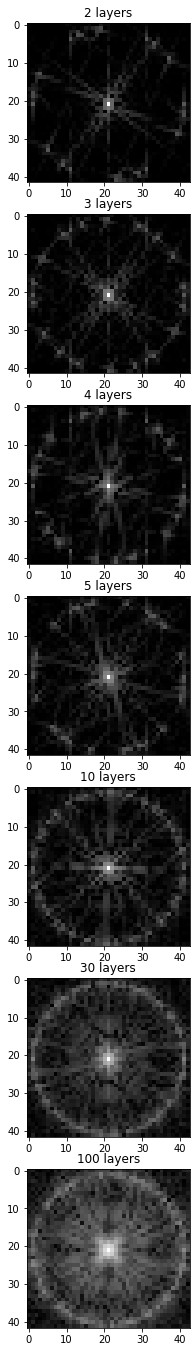

In [292]:
fig,axes = plt.subplots(nrows=len(n_layers_list),ncols=1, figsize=(12,24))
for i, n_layers in enumerate(n_layers_list):
  axes[i].imshow(np.log(1+intensities[i][0]),cmap='gray')
  axes[i].set_title('%i layers'%n_layers)